In [1]:
import matplotlib
matplotlib.use('nbagg')
print(matplotlib.get_backend())


nbAgg


In [2]:
import os
import matplotlib.pyplot as plt
from os import listdir
import random
import numpy as np
import cv2 as cv

loading data from directory

In [3]:
#dataset_location = 'C:/Users/sushl/Downloads/Visual-Odometry-master/Visual-Odometry-master/KITTI_sample/images'
#dataset_location = 'C:/Users/sushl/Downloads/Archives/data_odometry_gray/dataset/sequences/07/image_0'
#dataset_location = 'C:/Users/sushl/Desktop/visual odometry/vnit_dataset'
dataset_location = 'C:/Users/sushl/Desktop/visual odometry/adc'
L = os.listdir(dataset_location)
L.sort()

ground_truth

In [4]:
#ground_truth = np.loadtxt('C:/Users/sushl/Downloads/Visual-Odometry-master/Visual-Odometry-master/KITTI_sample/poses.txt',delimiter = ' ')
#ground_truth = np.loadtxt('C:/Users/sushl/Desktop/New Text Document.txt',delimiter = ' ')
ground_truth = np.loadtxt('C:/Users/sushl/Downloads/Archives/data_odometry_poses/dataset/poses/05.txt',delimiter = ' ')
ground_truth.shape
gx = ground_truth[:150,3]
gz = ground_truth[:150,11]

calibration matrix

In [5]:
k =np.array([[7.188560000000e+02, 0.000000000000e+00, 6.071928000000e+02], 
             [0.000000000000e+00, 7.188560000000e+02, 1.852157000000e+02], 
           [0.000000000000e+00, 0.000000000000e+00, 1.000000000000e+00]])

In [8]:
k = np.array([[518.56666108, 0., 329.45801792],
    [0., 518.80466479, 237.05589955],
    [  0., 0., 1.]])


In [9]:
sift = cv.SIFT_create()
bf = cv.BFMatcher()

function for triangulating Points

In [10]:
def point3D(k,R,t,pts1,pts2):
    rt = np.zeros((3,4))
    rt[:3,:3] = np.identity(3)
    projMatr1 = k@rt
    rt2 = np.zeros((3,4))
    rt2[:3,:3] = R
    rt2[:,3] = t.reshape((3))
    projMatr2 = k@rt2
    points4D = cv.triangulatePoints(projMatr1,projMatr2,pts1 ,pts2)
    points3D = points4D / points4D[3,:]
    return points3D.T

function for calculating scale

by finding distance ratio

In [11]:
def RelativeScale1(last_cloud, new_cloud):
    min_idx = min([new_cloud.shape[0],last_cloud.shape[0]])
    p_Xk = new_cloud[:min_idx]
    Xk = np.roll(p_Xk,shift = -10)
    p_Xk_1 = last_cloud[:min_idx]
    Xk_1 = np.roll(p_Xk_1,shift = -10)
    d_ratio = (np.linalg.norm(p_Xk_1 - Xk_1,axis = -1))/(np.linalg.norm(p_Xk - Xk,axis = -1))

    return np.median(d_ratio)

by projecting old 3d cloud on to the new one

In [12]:
def keypoints(img):
    corners = cv.goodFeaturesToTrack(img, mask = None, maxCorners = 1000, qualityLevel = 0.01, minDistance = 4, blockSize = 5, useHarrisDetector = True, k = 0.04  )
    #print(corners.shape)
    #print(corners.shape,corners)
    return corners


In [13]:
def optical_flow_matches(img,trig_frame,pt1):
    # Parameters for lucas kanade optical flow
    lk_params = dict( winSize  = (15,15),
                      maxLevel = 2,
                      criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))
    ptimg, st, err = cv.calcOpticalFlowPyrLK(trig_frame, img, pt1, None, **lk_params)

    pt1i, st, err = cv.calcOpticalFlowPyrLK(img, trig_frame, ptimg, None, **lk_params)
    return ptimg,pt1i
    

calculating trajectory by calculating scale

In [14]:
translations1 = []
translations1.append(np.zeros((3,1)))
rotations1 = []
rotations1.append(np.identity(3))
scale1 = []
pointcloud = []
img1 = cv.imread(dataset_location +'/'+ L[0],cv.IMREAD_GRAYSCALE)
pts1 = keypoints(img1) 
error_set = []
for a in range(140):
    old_cloud = pointcloud
    img2 = cv.imread(dataset_location +'/'+ L[a+1],cv.IMREAD_GRAYSCALE)
    pts1,pts2 = optical_flow_matches(img2,img1,pts1)
    #print(pts2)
    #E, mask = cv.findEssentialMat(pts1,pts2,k,cv.RANSAC, prob=0.999,threshold = 0.4 ,mask=None)
    F,mask = cv.findFundamentalMat(pts1, pts2,cv.FM_RANSAC ,0.4,0.9,mask=None)
    E = k.T@F@k
    # We select only inlier points
    pts1 = pts1[mask.ravel()==1]
    pts2 = pts2[mask.ravel()==1]
    pts1 = pts1.reshape((-1,1,2))
    pts2 = pts2.reshape((-1,1,2))
    
    retval, R, t, mask = cv.recoverPose(E, pts1, pts2, k)
    print(t)
    if a == 0:
        pointcloud = point3D(k,R,t,pts1,pts2)
        translations1.append(t)
        rotations1.append(R)
        pointcloud = pointcloud[:,:3]
        p3d = np.ones((4,pointcloud.shape[0]))
        p3d[:3,:] = pointcloud.T
        projection_mat = np.zeros((3,4))
        projection_mat[:3,:3] = rotations1[a]
        projection_mat[:,3] = translations1[a].reshape((3))
        proj_pt = k@projection_mat@p3d
        proj_pt = proj_pt.T
        proj_pt= proj_pt / proj_pt[:,2].reshape((-1,1))
        proj_pt = proj_pt[:,:2]
        err = proj_pt - pts2.reshape((-1,2))
        norm_err = np.linalg.norm(err, axis=1)
        error_set.append(np.min(norm_err))
        print(a,np.min(norm_err))

      
    elif a == len(L)-2:
        pointcloud = point3D(k,R,t,pts1,pts2)
        rotations1.append(rotations1[a]@R)
        s1 = RelativeScale1(old_cloud, pointcloud)
        #s1 = RelativeScale2(old_cloud, pointcloud,rotations[a+1],t)
        scale1.append(s1)
        translations1[a] = translations1[a-1] - s1*rotations1[a]@translations1[a]
        translations1.append(t+ translations1[a])
        pointcloud = pointcloud[:,:3]
        p3d = np.ones((4,pointcloud.shape[0]))
        p3d[:3,:] = pointcloud.T
        projection_mat = np.zeros((3,4))
        projection_mat[:3,:3] = rotations1[a]
        projection_mat[:,3] = translations1[a].reshape((3))
        proj_pt = k@projection_mat@p3d
        proj_pt = proj_pt.T
        proj_pt= proj_pt / proj_pt[:,2].reshape((-1,1))
        proj_pt = proj_pt[:,:2]
        err = proj_pt - pts2.reshape((-1,2))
        norm_err = np.linalg.norm(err, axis=1)
        error_set.append(np.min(norm_err))
        print(a,np.min(norm_err))
        
    else:
        pointcloud = point3D(k,R,t,pts1,pts2)
        rotations1.append(rotations1[a]@R)
        s1 = RelativeScale1(old_cloud, pointcloud)
        #s1 = RelativeScale2(old_cloud, pointcloud,rotations1[a+1],t)
        scale1.append(s1)
        translations1[a] = translations1[a-1] - s1*rotations1[a]@translations1[a]
        translations1.append(t)
        pointcloud = pointcloud[:,:3]
        p3d = np.ones((4,pointcloud.shape[0]))
        p3d[:3,:] = pointcloud.T
        projection_mat = np.zeros((3,4))
        projection_mat[:3,:3] = rotations1[a]
        projection_mat[:,3] = translations1[a].reshape((3))
        proj_pt = k@projection_mat@p3d
        proj_pt = proj_pt.T
        proj_pt= proj_pt / proj_pt[:,2].reshape((-1,1))
        proj_pt = proj_pt[:,:2]
        err = proj_pt - pts2.reshape((-1,2))
        norm_err = np.linalg.norm(err, axis=1)
        error_set.append(np.min(norm_err))
        print(a,np.min(norm_err))
    
    pts1 = keypoints(img2)
    img1 = img2[:]

[[-0.79547297]
 [-0.11304156]
 [ 0.5953523 ]]
0 1.6230155626039853
[[-0.61623543]
 [-0.02836123]
 [ 0.78705117]]
1 8.087206484671672
[[-0.13207914]
 [ 0.20703588]
 [-0.96937673]]
2 0.2866736500509568
[[-0.47690199]
 [-0.04256358]
 [ 0.8779253 ]]
3 10.324285326143874
[[-0.00599855]
 [ 0.19457506]
 [-0.98086929]]
4 4.32873501428616
[[-0.59727143]
 [-0.1150147 ]
 [ 0.79374962]]
5 13.396235291347242
[[ 0.07960392]
 [-0.21865812]
 [ 0.97254915]]
6 1.5310053781766462
[[-0.05914196]
 [ 0.17322124]
 [-0.9831056 ]]
7 0.4517641141654944
[[-0.1023741 ]
 [ 0.02699172]
 [-0.9943797 ]]
8 0.07479787970878347
[[-0.04743318]
 [ 0.31044378]
 [-0.94940758]]
9 2.8049942906713894
[[-0.11488643]
 [ 0.02614945]
 [ 0.9930344 ]]
10 5.8938069451858315
[[ 0.17070176]
 [ 0.3208363 ]
 [-0.93162491]]
11 7.9214845976773995
[[-0.41974083]
 [ 0.39257103]
 [ 0.81835543]]
12 24.539938357417327
[[ 0.15216117]
 [-0.24065671]
 [ 0.95860906]]
13 102.78161507472127
[[-0.51137294]
 [-0.04629754]
 [ 0.85811087]]
14 22.41083597

[[ 0.23314731]
 [-0.82862534]
 [ 0.50894241]]
125 326.35413020856146
[[ 0.43672461]
 [-0.62600097]
 [ 0.64606068]]
126 1440.784479031948
[[ 0.20461845]
 [-0.081491  ]
 [ 0.97544375]]
127 182.33179632601178
[[-0.10193035]
 [ 0.41786798]
 [-0.9027716 ]]
128 172.0875974303979
[[0.49932492]
 [0.07464446]
 [0.86319339]]
129 1599.549923655344
[[ 0.54654428]
 [ 0.17698234]
 [-0.81851487]]
130 116.84082859648365
[[-0.36450875]
 [-0.07444083]
 [ 0.92821977]]
131 270.4984885547359
[[-0.92007741]
 [ 0.29855459]
 [ 0.25361923]]
132 2069.4058225965564
[[-0.05717216]
 [-0.17068597]
 [ 0.98366541]]
133 197.05654513237994
[[-0.67948984]
 [ 0.17744464]
 [-0.71190375]]
134 1240.7686815555264
[[-0.18160978]
 [-0.40039799]
 [ 0.89816442]]
135 188.8545779991703
[[ 0.07980518]
 [ 0.2801035 ]
 [-0.95664683]]
136 356.32337970151116
[[ 0.40609066]
 [ 0.25233982]
 [-0.87830234]]
137 198.32412369510126
[[-0.19573332]
 [-0.0794636 ]
 [ 0.97743235]]
138 445.1540505388676
[[-0.63702016]
 [-0.27878089]
 [ 0.71866998

<IPython.core.display.Javascript object>


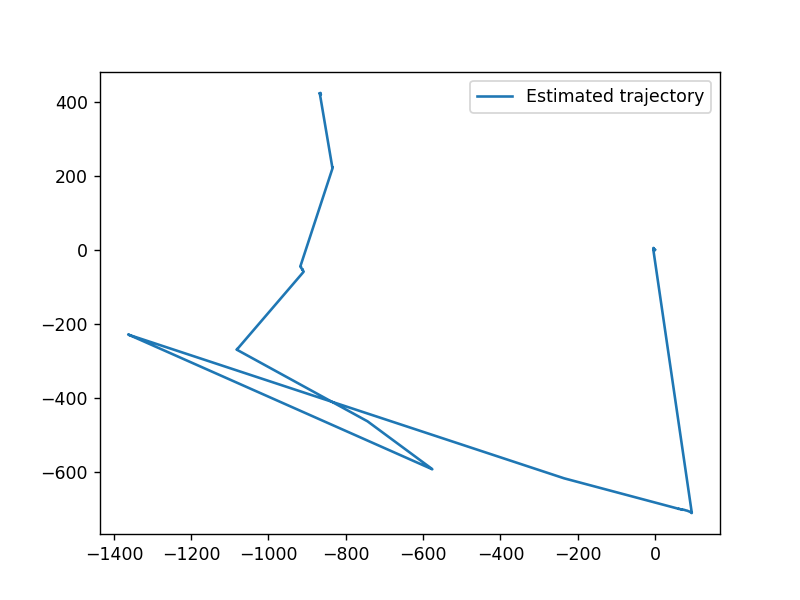

In [16]:
x0 = []
y0 = []

for i in range(136):
    y0.append(-1*translations1[i][2])
    x0.append(-1*translations1[i][0])

fig,axes = plt.subplots()
axes.plot(x0,y0,label = 'Estimated trajectory')
#axes.plot(gx, gz,color = 'red',label = 'Ground truth')
axes.legend()
plt.show()

<IPython.core.display.Javascript object>


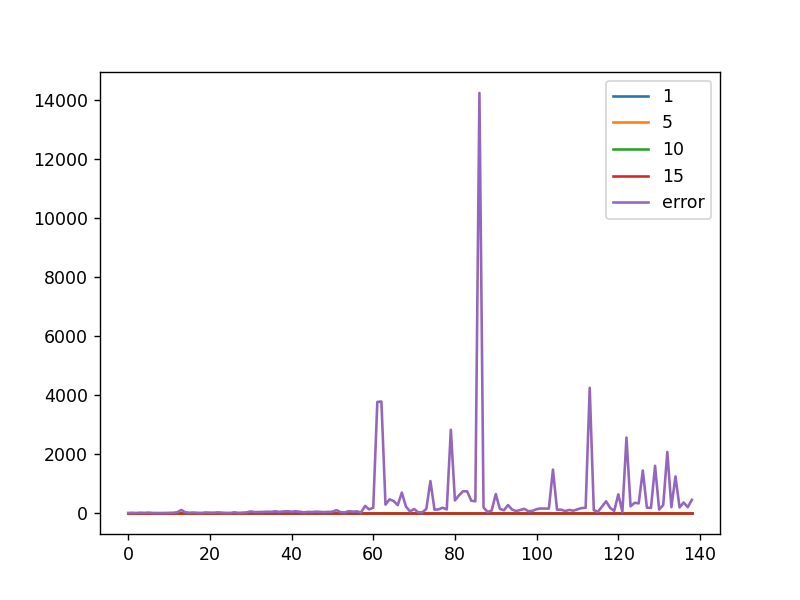

In [17]:
x0 = []
x1 = []
x2 = []
y0 = []
y1 = []
y2 = []
for i in range(len(error_set)-1):
    y0.append(error_set[i])
    x0.append(i)
    y1.append(1)
    y2.append(5)
    x1.append(10)
    x2.append(15)
    
fig,axes = plt.subplots()
axes.plot(x0, y1,label = '1')
axes.plot(x0, y2,label = '5')
axes.plot(x0, x1,label = '10')
axes.plot(x0, x2,label = '15')
axes.plot(x0, y0,label = 'error')
axes.legend()

plt.show()